As a starting point, we have to read in all dataframes that have the word 'acquisition' and merge them into one dataframe.  Each of these CSV files contains info about a different bank.

In [2]:
import pandas as pd
import glob

acquisition_files = glob.glob("*acquisitions.csv")

acquisitions_df = [pd.read_csv(filename) for filename in acquisition_files]
acquisitions_df = pd.concat(acquisitions_df, axis=0, ignore_index=True)
acquisitions_df

,loan_id,orig_channel,seller_name,orig_int_rate,original_upb,original_loan_term,orig_date,first_pymt_date,orig_ltv,orig_cltv,...,number_units,occ_type,prop_state,zip_code,primary_insurance_pct,product_type,coborrower_credit_score,mortgage_insurance_type,relo_mortgage_indicator,current_delq_status
0,1.001134e+11,B,"FLAGSTAR BANK, FSB",6.375,73000.0,360.0,01/2005,03/2005,80.0,80.0,...,1.0,P,MI,492.0,NaN,FRM,NaN,NaN,N,1.0
1,1.001134e+11,B,"FLAGSTAR BANK, FSB",5.750,70000.0,360.0,02/2005,04/2005,72.0,72.0,...,1.0,P,MO,656.0,NaN,FRM,761.0,NaN,N,1.0
2,1.001673e+11,C,"FLAGSTAR BANK, FSB",6.125,180000.0,240.0,01/2005,03/2005,58.0,58.0,...,1.0,P,CA,934.0,NaN,FRM,NaN,NaN,N,1.0
3,1.002136e+11,B,"FLAGSTAR BANK, FSB",5.375,122000.0,180.0,12/2004,02/2005,85.0,85.0,...,1.0,P,MI,481.0,6.0,FRM,675.0,1.0,N,1.0
4,1.002599e+11,C,"FLAGSTAR BANK, FSB",5.375,206000.0,180.0,02/2005,04/2005,53.0,53.0,...,3.0,P,CA,900.0,NaN,FRM,NaN,NaN,N,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231492,9.998117e+11,C,"CITIMORTGAGE, INC.",4.875,70000.0,180.0,01/2005,03/2005,25.0,25.0,...,1.0,P,PA,156.0,NaN,FRM,789.0,NaN,N,1.0
231493,9.998226e+11,C,"CITIMORTGAGE, INC.",6.000,75000.0,360.0,12/2004,02/2005,75.0,75.0,...,1.0,P,WV,249.0,NaN,FRM,NaN,NaN,N,1.0
231494,9.998283e+11,C,"CITIMORTGAGE, INC.",5.500,204000.0,360.0,01/2005,03/2005,65.0,65.0,...,1.0,P,NJ,88.0,NaN,FRM,786.0,NaN,N,1.0
231495,9.998401e+11,R,"CITIMORTGAGE, INC.",5.875,315000.0,360.0,12/2004,02/2005,62.0,62.0,...,1.0,P,CA,956.0,NaN,FRM,NaN,NaN,N,1.0


Next, we'll read in the data for foreclosed loans and merge them with acquisitions.  The merge will have to be a left join, since not all acquisitions were foreclosed.

In [3]:
foreclosed_df = pd.read_csv("foreclosed_loans.csv")
all_loans = acquisitions_df.merge(foreclosed_df, how="left")

all_loans

,loan_id,orig_channel,seller_name,orig_int_rate,original_upb,original_loan_term,orig_date,first_pymt_date,orig_ltv,orig_cltv,...,prop_state,zip_code,primary_insurance_pct,product_type,coborrower_credit_score,mortgage_insurance_type,relo_mortgage_indicator,current_delq_status,foreclosure_date,foreclosure_flag
0,1.001134e+11,B,"FLAGSTAR BANK, FSB",6.375,73000.0,360.0,01/2005,03/2005,80.0,80.0,...,MI,492.0,NaN,FRM,NaN,NaN,N,1.0,NaN,NaN
1,1.001134e+11,B,"FLAGSTAR BANK, FSB",5.750,70000.0,360.0,02/2005,04/2005,72.0,72.0,...,MO,656.0,NaN,FRM,761.0,NaN,N,1.0,NaN,NaN
2,1.001673e+11,C,"FLAGSTAR BANK, FSB",6.125,180000.0,240.0,01/2005,03/2005,58.0,58.0,...,CA,934.0,NaN,FRM,NaN,NaN,N,1.0,NaN,NaN
3,1.002136e+11,B,"FLAGSTAR BANK, FSB",5.375,122000.0,180.0,12/2004,02/2005,85.0,85.0,...,MI,481.0,6.0,FRM,675.0,1.0,N,1.0,NaN,NaN
4,1.002599e+11,C,"FLAGSTAR BANK, FSB",5.375,206000.0,180.0,02/2005,04/2005,53.0,53.0,...,CA,900.0,NaN,FRM,NaN,NaN,N,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231492,9.998117e+11,C,"CITIMORTGAGE, INC.",4.875,70000.0,180.0,01/2005,03/2005,25.0,25.0,...,PA,156.0,NaN,FRM,789.0,NaN,N,1.0,NaN,NaN
231493,9.998226e+11,C,"CITIMORTGAGE, INC.",6.000,75000.0,360.0,12/2004,02/2005,75.0,75.0,...,WV,249.0,NaN,FRM,NaN,NaN,N,1.0,NaN,NaN
231494,9.998283e+11,C,"CITIMORTGAGE, INC.",5.500,204000.0,360.0,01/2005,03/2005,65.0,65.0,...,NJ,88.0,NaN,FRM,786.0,NaN,N,1.0,NaN,NaN
231495,9.998401e+11,R,"CITIMORTGAGE, INC.",5.875,315000.0,360.0,12/2004,02/2005,62.0,62.0,...,CA,956.0,NaN,FRM,NaN,NaN,N,1.0,NaN,NaN


The **foreclosure_flag** column has a value of '1' when a loan was foreclosed.  It will make things easier later if all NaN values (i.e., loans that were not foreclosed) had a value of '0' instead.

In [13]:
all_loans.foreclosure_flag.loc[all_loans.foreclosure_flag.isnull()] = 0

/usr/local/Cellar/jupyterlab/2.1.2/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
all_loans.foreclosure_flag.unique()

array([0., 1.])

What we want to explore is which factors contribute the most to foreclosure.  We want to know what patterns exist that increase the likelihood that a loan will be foreclosed.  In other words, we want to hone in on the most important **predictor variables**.

As a starting point, let's look at 3 factors that banks usually look at to determine whether a borrower is credit worthy:

### 1. Credit score
From Investopedia:

> A credit score is a number ranging from 300-850 that depicts a consumer's creditworthiness. The higher the credit score, the more attractive the borrower.


### 2. Loan-to-value ratio (LTV)
This represents the total \\$ value of the mortgage divided by the \\$ appraised value of the house. For example, if you buy a house for $100,000 and put \\$20k down, you will need a mortgage of \\$80k. The LTV of this purchase would be 80\% (80k/100k).

If the LTV is higher, that means that you have less equity in the house. Higher LTVs are
traditionally considered to be riskier.


### 3. Debt-to-Income ratio (DTI)
DTI stands for Debt to Income. This represents total debt payments the borrower needs to
make in a month divided by their monthly gross income (including the mortgage payment
itself).

For Example – If you have a \\$500 Car Payment and a \\$2000 Mortgage and gross income of
\\$5000 a month, your DTI would be 50% (\\$2500 ÷ \\$5000). Typically, a higher DTI is riskier.

Let's take a look at some summary stats comparing the difference between these foreclose loans and non-foreclosed loans.

Then, let's create some plots to get a visual feel for the data.

In [5]:
# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# summarize all loans
all_loans.describe()

,loan_id,orig_int_rate,original_upb,original_loan_term,orig_ltv,orig_cltv,num_borrowers,orig_dti,credit_score,number_units,zip_code,primary_insurance_pct,coborrower_credit_score,mortgage_insurance_type,current_delq_status,foreclosure_flag
count,231497.00,231497.00,231497.00,231497.00,231497.00,231481.00,231496.00,211948.00,229423.00,231497.00,231497.00,29364.00,103196.00,29364.00,231497.00,9533.00
mean,548973076686.20,5.68,166677.57,313.79,68.31,70.03,1.58,36.23,721.34,1.04,517.92,22.88,729.19,1.05,1.00,1.00
std,259775197712.91,0.36,83467.86,77.77,17.21,17.97,0.51,13.18,57.99,0.24,309.48,7.24,57.06,0.22,0.00,0.00
min,100000102115.00,4.00,9000.00,84.00,1.00,1.00,1.00,1.00,384.00,1.00,8.00,6.00,391.00,1.00,1.00,1.00
25%,324226648577.00,5.50,100000.00,240.00,58.00,60.00,1.00,26.00,679.00,1.00,272.00,17.00,688.00,1.00,1.00,1.00
50%,548746176407.00,5.75,150000.00,360.00,73.00,74.00,2.00,36.00,727.00,1.00,486.00,25.00,738.00,1.00,1.00,1.00
75%,774045838484.00,5.88,220000.00,360.00,80.00,80.00,2.00,46.00,771.00,1.00,837.00,30.00,777.00,1.00,1.00,1.00
max,999996197450.00,9.00,692000.00,360.00,97.00,193.00,5.00,64.00,850.00,4.00,999.00,39.00,842.00,2.00,1.00,1.00


In [16]:
# summarize foreclosed loans only
all_loans[all_loans.foreclosure_flag==1].describe()

,loan_id,orig_int_rate,original_upb,original_loan_term,orig_ltv,orig_cltv,num_borrowers,orig_dti,credit_score,number_units,zip_code,primary_insurance_pct,coborrower_credit_score,mortgage_insurance_type,current_delq_status,foreclosure_flag
count,9533.00,9533.00,9533.00,9533.00,9533.00,9533.00,9533.00,8647.00,9444.00,9533.00,9533.00,2685.00,3258.00,2685.00,9533.00,9533.00
mean,549813815454.31,5.85,157561.73,342.47,77.89,79.31,1.43,39.49,690.08,1.04,527.98,24.19,694.10,1.07,1.00,1.00
std,258555540563.44,0.34,80073.76,50.32,11.79,12.38,0.51,11.89,53.91,0.25,276.84,6.72,52.75,0.25,0.00,0.00
min,100312772807.00,4.50,13000.00,120.00,14.00,14.00,1.00,2.00,442.00,1.00,10.00,6.00,457.00,1.00,1.00,1.00
25%,324984199913.00,5.62,95000.00,360.00,71.00,72.00,1.00,31.00,653.00,1.00,329.00,25.00,659.00,1.00,1.00,1.00
50%,554869727083.00,5.88,144000.00,360.00,80.00,80.00,1.00,40.00,686.00,1.00,482.00,25.00,692.00,1.00,1.00,1.00
75%,775910732827.00,6.00,208000.00,360.00,85.00,90.00,2.00,48.00,728.00,1.00,805.00,30.00,731.00,1.00,1.00,1.00
max,999694740640.00,8.00,478000.00,360.00,97.00,145.00,4.00,64.00,844.00,4.00,997.00,35.00,842.00,2.00,1.00,1.00


In [17]:
# summarize non-foreclosed loans
all_loans[all_loans.foreclosure_flag==0].describe()

,loan_id,orig_int_rate,original_upb,original_loan_term,orig_ltv,orig_cltv,num_borrowers,orig_dti,credit_score,number_units,zip_code,primary_insurance_pct,coborrower_credit_score,mortgage_insurance_type,current_delq_status,foreclosure_flag
count,221964.00,221964.00,221964.00,221964.00,221964.00,221948.00,221963.00,203301.00,219979.00,221964.00,221964.00,26679.00,99938.00,26679.00,221964.00,221964.00
mean,548936968296.21,5.67,167069.08,312.56,67.90,69.63,1.58,36.09,722.68,1.04,517.49,22.75,730.34,1.05,1.00,0.00
std,259827970703.97,0.36,83588.46,78.50,17.29,18.06,0.51,13.21,57.78,0.24,310.80,7.27,56.84,0.21,0.00,0.00
min,100000102115.00,4.00,9000.00,84.00,1.00,1.00,1.00,1.00,384.00,1.00,8.00,6.00,391.00,1.00,1.00,0.00
25%,324197362010.50,5.50,100000.00,240.00,58.00,59.00,1.00,26.00,680.00,1.00,253.00,17.00,690.00,1.00,1.00,0.00
50%,548542639218.50,5.75,150000.00,360.00,73.00,74.00,2.00,36.00,729.00,1.00,487.00,25.00,740.00,1.00,1.00,0.00
75%,773992835015.50,5.88,220000.00,360.00,80.00,80.00,2.00,46.00,772.00,1.00,837.00,30.00,778.00,1.00,1.00,0.00
max,999996197450.00,9.00,692000.00,360.00,97.00,193.00,5.00,64.00,850.00,4.00,999.00,39.00,839.00,2.00,1.00,0.00


Now let's plot them.

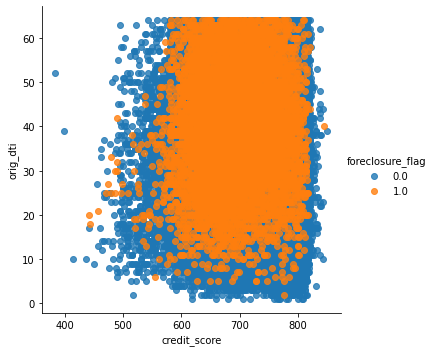

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

credit_plot = sns.lmplot("credit_score", 
                         "orig_dti",
                         hue="foreclosure_flag",
                         data=all_loans,
                         fit_reg=False)
plt.show()

In [26]:
all_loans.foreclosure_flag.value_counts()

0.00    221964
1.00      9533
Name: foreclosure_flag, dtype: int64